<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-MCD/blob/main/16-RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>RAG</h1>

<h3>Retrieval-augmented generation</h3>

RAG (*generación aumentada por recuperación*, por sus siglas en inglés) es una técnica que complementa la generación de texto con información de fuentes de datos. Combina un modelo de recuperación, que está diseñado para buscar en bases de conocimiento, con un modelo LLM, el cual que toma esa información y genera una respuesta en lenguaje natural.

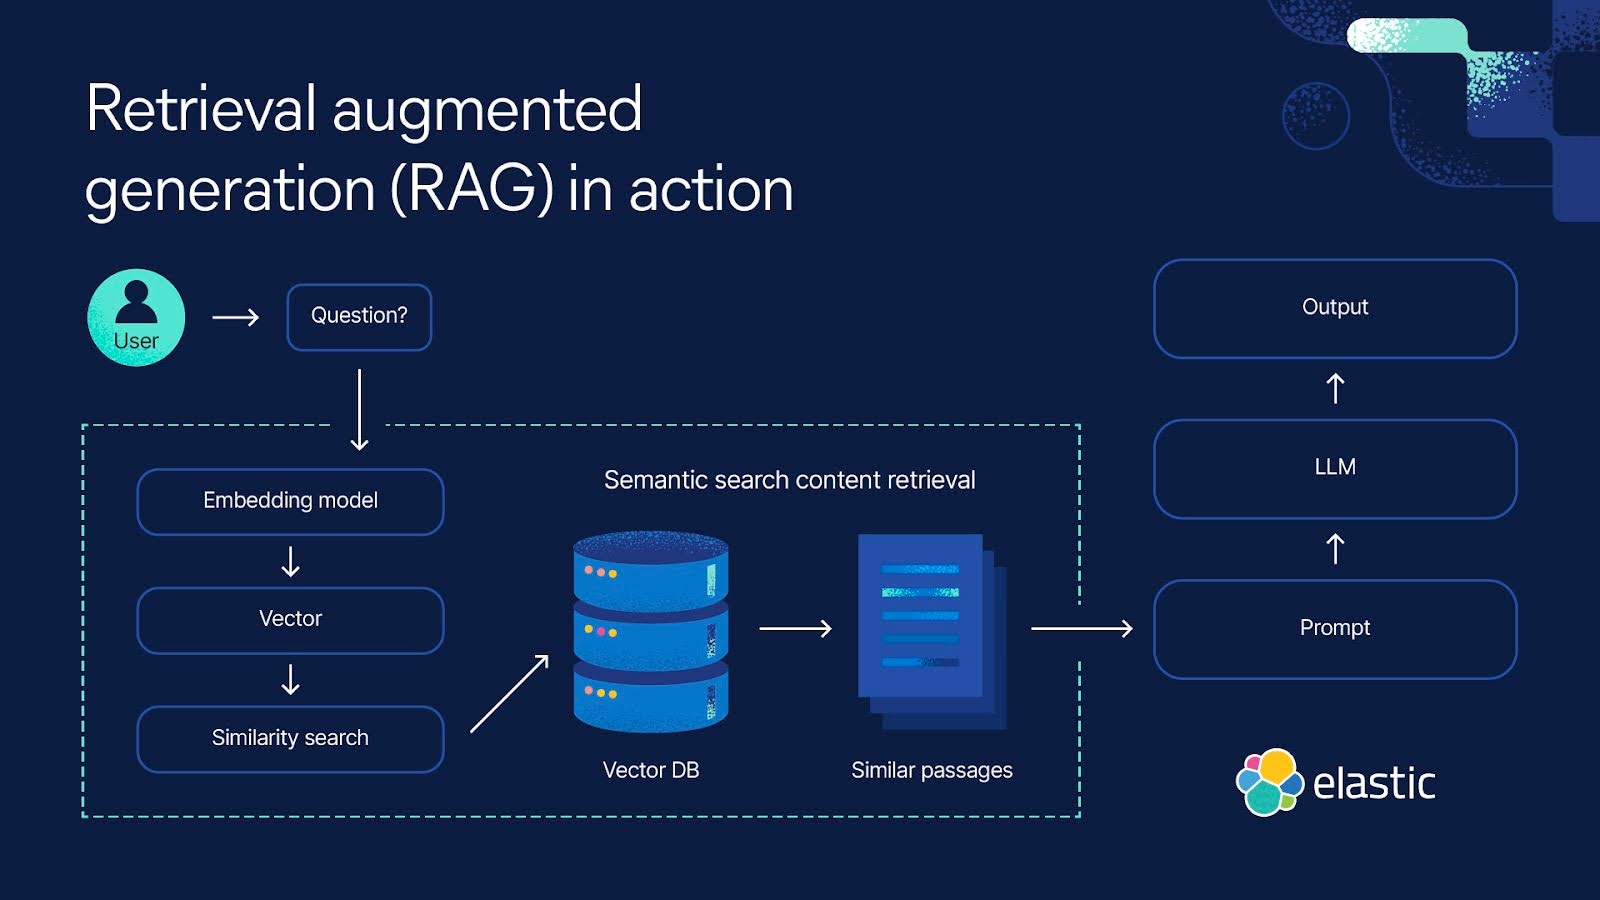

En esta notebook construiremos un modelo sencillo RAG para hacer consultas sobre información de los posgrados en la Universidad de Sonora. Usaremos el framework LangChain.

Comencemos haciendo algunas consultas con algunos LLMs. Preguntemos *¿cuánto dura la maestría en ciencia de datos de la universidad de sonora?*:

* ChatGPT.
* Algún modelo en Huggingface, [ejemplo](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct).
* Un modelo local.

¿Cuál es la diferencia entre ellos? ¿en qué radica el poder dar la respuesta correcta y relevante?

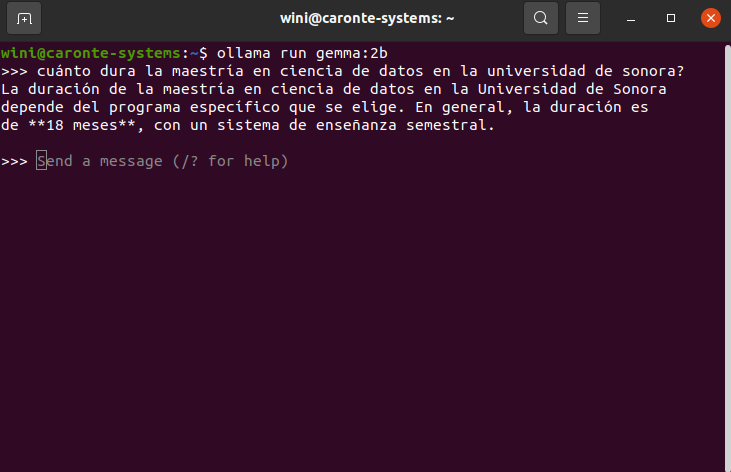

La respuesta es **RAG**. Veamos como funciona:

Instalamos los módulos necesarios

In [1]:
!pip install pypdf                  # Leer archivos PDF
!pip install -U langchain-community # Third-party integrations for LangChain
!pip install langchain              # Framework for developing applications powered by LLMs
!pip install chromadb               # Vector storage database
!pip install boto3                  # Modulo para autentificarse en AWS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.19
    Uninstalling langchain-core-0.3.19:
      Successfully uninstalled langchain-core-0.3.19
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.7
    Uninstalling langchain-0.3.7:
      Successfully uninstalled langchain-0.3.7
     ━━━

Bajar algunos documentos PDF

In [2]:
!gdown 1sI80RrVCqGEGWkt2_K0N_q_c4mGquF7Q
!gdown 1eIoAGI4_YleCyynwzkLB-0DslwVYxiv0

Downloading...
From: https://drive.google.com/uc?id=1sI80RrVCqGEGWkt2_K0N_q_c4mGquF7Q
To: /content/MCD Lineamientos-internos.pdf
100% 106k/106k [00:00<00:00, 4.44MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eIoAGI4_YleCyynwzkLB-0DslwVYxiv0
To: /content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf
100% 150k/150k [00:00<00:00, 4.95MB/s]


## Leemos los documentos PDF

Leemos todos los documentos de la carpeta `path` en un arreglo de `Document`, cada uno de ellos contiene información sobre la ruta del archivo y el contenido de cada página.

In [3]:
from langchain.document_loaders.pdf import PyPDFDirectoryLoader

def load_documents(path):
    document_loader = PyPDFDirectoryLoader(path)
    return document_loader.load()

In [4]:
path = '/content'

documents = load_documents(path)
documents[1]

Document(metadata={'source': '/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf', 'page': 1}, page_content='relevancia social, en función de los requerimientos socioeconómicos, culturales e históricos de la nación.\nDe ahí la necesidad de impulsar y reglamentar los estudios de posgrado que ofrece la Universidad de\nSonora.\nLa Ley Número 4 Orgánica que rige esta institución ha consolidado una estructura académica cuyo\nmodelo organizativo propicia la vinculación de la docencia y la investigación. De ahí que los estudios de\nposgrado, tanto por su incidencia en la formación de investigadores y en el desarrollo y apertura de líneas\nde investigación, como por su participación directa en la formación de cuadros profesionales de alto nivel,\nocupen un lugar destacado en la ascendente dinámica de nuestra casa de estudios. Prueba de ello es el\ncreciente número de posgrados que ha venido aumentado la oferta de programas de este nivel en todas\nlas áreas del conocimiento q

## Dividimos los documentos PDF en trozos

Usamos el [RecursiveCharacterTextSplitter](https://python.langchain.com/api_reference/text_splitters/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html#langchain_text_splitters.character.RecursiveCharacterTextSplitter) de LangChain

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema.document import Document

def split_documents(documents: list[Document]):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,
        chunk_overlap=80,
        length_function=len,
        is_separator_regex=False,
    )
    return text_splitter.split_documents(documents)

In [6]:
chunks = split_documents(documents)

In [7]:
print(chunks[0])
print(30*"-")
print(chunks[1])

page_content='REGLAMENTO DE ESTUDIOS DE POSGRADO
EXPOSICIÓN DE MOTIVOS
ÁMBITO DE VALIDEZ
ÁMBITO DE COMPETENCIA Y ORIENTACIONES GENERALES
CAPÍTULO I
Disposiciones Generales
CAPÍTULO II
De la organización
CAPÍTULO III
Del Personal Académico
CAPÍTULO IV
De los Planes y Programas de Estudio
CAPÍTULO V
De los Programas de Posgrado Interinstitucionales
CAPÍTULO VI
De los Estudiantes
CAPÍTULO VII
De los Derechos y Obligaciones de los Estudiantes
CAPÍTULO VIII
De las Inscripciones
CAPÍTULO IX
De las Reinscripciones
CAPÍTULO X
De las Evaluaciones
CAPÍTULO XI
De las Bajas
CAPÍTULO XII
De los Diplomas y Grados
CAPÍTULO XIII
De la Revalidación, Equivalencia y Conmutación
TRANSITORIOS
EXPOSICIÓN DE MOTIVOS
Las transformaciones sociales, económicas y políticas en el nivel nacional e internacional que se viven' metadata={'source': '/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf', 'page': 0}
--------------------
page_content='actualmente plantean a la educación superior nuevos r

## Asignamos un embedding a cada trozo y almacenamos los embeddings en una base de datos

* [Bedrock embeddings](https://python.langchain.com/api_reference/aws/embeddings/langchain_aws.embeddings.bedrock.BedrockEmbeddings.html). Titan Embeddings de [AWS](https://aws.amazon.com/bedrock/?nc1=h_ls) (más [detalles](https://www.philschmid.de/amazon-titan-embeddings) de los embeddings).
* [HuggingFace embeddings](https://api.python.langchain.com/en/latest/huggingface/embeddings/langchain_huggingface.embeddings.huggingface.HuggingFaceEmbeddings.html). Embeddings de [Sentence BERT](https://huggingface.co/sentence-transformers/all-mpnet-base-v2).

In [8]:
!pip install -qU langchain-huggingface

In [9]:
from langchain_community.embeddings.ollama import OllamaEmbeddings
from langchain_community.embeddings.bedrock import BedrockEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

def get_embedding_function():
    # embeddings = BedrockEmbeddings(
    #     credentials_profile_name="default", region_name="us-east-1"
    # )
    # embeddings = OllamaEmbeddings(model="nomic-embed-text")
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    return embeddings

In [10]:
from langchain.vectorstores.chroma import Chroma

CHROMA_PATH = "chroma"

def add_to_chroma(chunks: list[Document]):
    # Leer la DB existente
    db = Chroma(
        persist_directory=CHROMA_PATH, embedding_function=get_embedding_function()
    )

    # Calcular los IDs de chunks.
    chunks_with_ids = calculate_chunk_ids(chunks)

    # Agregar o actualizar documentos.
    existing_items = db.get(include=[])
    existing_ids = set(existing_items["ids"])
    print(f"Número de documentos existentes en la DB: {len(existing_ids)}")

    # Sólo agregar los documentos que no estén en la DB.
    new_chunks = []
    for chunk in chunks_with_ids:
        if chunk.metadata["id"] not in existing_ids:
            new_chunks.append(chunk)

    if len(new_chunks):
        print(f"Agregando {len(new_chunks)} nuevos documentos")
        new_chunk_ids = [chunk.metadata["id"] for chunk in new_chunks]
        db.add_documents(new_chunks, ids=new_chunk_ids)
        db.persist()
    else:
        print("No hay nuevos documentos para agregar")

def calculate_chunk_ids(chunks):

    # Función para crear los IDs de tipo "content/file.pdf:6:2"
    # Page Source : Page Number : Chunk Index

    last_page_id = None
    current_chunk_index = 0

    for chunk in chunks:
        source = chunk.metadata.get("source")
        page = chunk.metadata.get("page")
        current_page_id = f"{source}:{page}"

        # Si el page ID es el mismo que el anterior, incrementar el índice
        if current_page_id == last_page_id:
            current_chunk_index += 1
        else:
            current_chunk_index = 0

        # Calcular el chunk ID.
        chunk_id = f"{current_page_id}:{current_chunk_index}"
        last_page_id = current_page_id

        # Add it to the page meta-data.
        chunk.metadata["id"] = chunk_id

    return chunks

Contruimos o actualizamos la DB

In [11]:
add_to_chroma(chunks)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-10-ec391f18a71f>:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(


Número de documentos existentes en la DB: 0
Agregando 99 nuevos documentos


<ipython-input-10-ec391f18a71f>:29: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  db.persist()


## Interrogamos al LLM sobre cualquier tópico

Usaremos un LLM de transformers de HuggingFace.

Definimos el modelo:

In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# model_name = "Qwen/Qwen2.5-1.5B-Instruct"
# model_name = "Qwen/Qwen-7B-Chat"
# model_name = "mosaicml/mpt-7b""
# model_name = "tiiuae/falcon-7b-instruct"
model_name = "microsoft/Phi-3.5-mini-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

La función para interrogar al LLM con RAG

In [13]:
import argparse
from langchain.vectorstores.chroma import Chroma
from langchain.prompts import ChatPromptTemplate

PROMPT_TEMPLATE = """
Answer the question based only on the following context:

{context}

---

Answer the question based on the above context: {question}
"""

def query_rag(query_text: str):
    # Preparar la DB
    embedding_function = get_embedding_function()
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)

    # Buscar en la DB
    results = db.similarity_search_with_score(query_text, k=5)

    context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)
    # print(prompt)

    messages = [
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
    )

    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=256
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    sources = [doc.metadata.get("id", None) for doc, _score in results]
    formatted_response = f"Response: {response_text}\nSources:\n"
    print(formatted_response)
    # Listar las fuentes
    for source in sources:
        print(source,end="\n------------\n")
    return response_text




Finalmente podemos hacer las consultas al LLM

In [ ]:
query_rag("CUAL ES EL MECANISMO PARA GRADUARSE DE UNA MAESTRIA?")

Response: Para graduarse de una maestría, se deben cumplir los siguientes requisitos según el contexto proporcionado:

I. Aprobar el total de los créditos y cumplir con los demás requisitos establecidos en el programa de posgrado correspondiente.
II. Acreditar la comprensión de un idioma diferente al español, según lo establezca la Comisión Académica del Posgrado de acuerdo al programa de estudio.
III. Aprobar el examen de grado en la fase escrita y en la fase oral ante un jurado nombrado exprofeso.

Además, para los programas de maestría con orientación profesional, el objetivo es preparar al estudiante para una mejor práctica de su profesión, proporcionándole conocimientos científicos y técnicos para darle una mayor competencia profesional y la capacidad para generar ventajas competitivas al sector profesional para el cual labora.
Sources: ['/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:16:0', '/content/Reglamento de Estudios de Posgrado Universidad de Sonora.

'Para graduarse de una maestría, se deben cumplir los siguientes requisitos según el contexto proporcionado:\n\nI. Aprobar el total de los créditos y cumplir con los demás requisitos establecidos en el programa de posgrado correspondiente.\nII. Acreditar la comprensión de un idioma diferente al español, según lo establezca la Comisión Académica del Posgrado de acuerdo al programa de estudio.\nIII. Aprobar el examen de grado en la fase escrita y en la fase oral ante un jurado nombrado exprofeso.\n\nAdemás, para los programas de maestría con orientación profesional, el objetivo es preparar al estudiante para una mejor práctica de su profesión, proporcionándole conocimientos científicos y técnicos para darle una mayor competencia profesional y la capacidad para generar ventajas competitivas al sector profesional para el cual labora.'

In [14]:
query_rag("cuánto dura la maestría en ciencia de datos?")

/content/MCD Lineamientos-internos.pdf:3:0
------------
/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:5:1
------------
/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:16:0
------------
/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:11:2
------------
/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:13:2
------------
Response: La maestría en ciencia de datos dura dos años y seis meses. Este plazo se detalla en el ARTÍCULO 66 del contexto proporcionado, especificando los plazos máximos para concluir el plan de estudios y la obtención del grado para programas de posgrado que aceptan estudiantes con dedicación de tiempo completo.
Sources:


'La maestría en ciencia de datos dura dos años y seis meses. Este plazo se detalla en el ARTÍCULO 66 del contexto proporcionado, especificando los plazos máximos para concluir el plan de estudios y la obtención del grado para programas de posgrado que aceptan estudiantes con dedicación de tiempo completo.'

In [ ]:
query_rag("cuánto dura una maestría en la unison?")

Response: El contexto proporcionado no especifica la duración de un programa de maestría en la Unison. Para obtener esa información, sería necesario consultar el Reglamento o los programas de estudios específicos que no se mencionan en el texto proporcionado.
Sources: ['/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:20:1', '/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:21:0', '/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:19:1', '/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:2:4', '/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:19:2']


'El contexto proporcionado no especifica la duración de un programa de maestría en la Unison. Para obtener esa información, sería necesario consultar el Reglamento o los programas de estudios específicos que no se mencionan en el texto proporcionado.'

La calidad de las respuestas depende de:

* Documentos de consulta
* División de los documentos de consulta
* Embeddings
* Prompt
* LLM

¿Cómo podemos evaluar la calidad de este sistema?

## Further Reading and Techniques

* Curso Gratis de Nvidia: https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+S-FX-15+V1
* Advanced RAG Techniques: Collection of RAG tutorials: https://github.com/NirDiamant/RAG_Techniques